In [29]:
import pandas as pd
import numpy as np
%matplotlib inline

### Get the Data from Zillow
This is a very preliminary research. I just had a look and play with the data available on Zillow. Hopefully will be useful for you and hopefully should at least provide some pointers for cities to target. 

**The Approach**
1. Get the latest median price of all cities, type = "Single Family Home" (note there is suburb level data but decided for simplicity to start with)
2. Get the latest median rent of all cities, type = "Single Family Home" (note for both items 1 and 2, there are other types of properties)
3. Match rent to price on location (i.e. Region-State pair)
4. Compute the gross yield (i.e. median_monthly_rent * 12 / median_price)
5. Select top cities (i.e. biggest cities in SizeRank) and sort by gross yield.

**A few interesting pages**
* A nice summary of different cities: http://www.zillow.com/research/local-market-reports/
* All the data: http://www.zillow.com/research/data/#rental-data
* A page on Zillow rent index: http://www.zillow.com/research/zillow-rent-index-methodology-2393/

**Remarks**
* Using median is a pretty simple yet rough statistical measure
* Only looked at single family home

In [1]:
!wget http://files.zillowstatic.com/research/public/City/City_Zhvi_SingleFamilyResidence.csv

--2015-11-23 22:12:02--  http://files.zillowstatic.com/research/public/City/City_Zhvi_SingleFamilyResidence.csv
Resolving files.zillowstatic.com (files.zillowstatic.com)... 192.211.12.34
Connecting to files.zillowstatic.com (files.zillowstatic.com)|192.211.12.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17157048 (16M) [text/csv]
Saving to: 'City_Zhvi_SingleFamilyResidence.csv’

City_Zhvi_SingleFam 100%[=====================>]  16.36M   247KB/s   in 2m 13s 

2015-11-23 22:14:16 (126 KB/s) - 'City_Zhvi_SingleFamilyResidence.csv’ saved [17157048/17157048]



In [3]:
!wget http://files.zillowstatic.com/research/public/City/City_MedianRentalPrice_Sfr.csv

--2015-11-23 22:14:27--  http://files.zillowstatic.com/research/public/City/City_MedianRentalPrice_Sfr.csv
Resolving files.zillowstatic.com (files.zillowstatic.com)... 192.211.12.34
Connecting to files.zillowstatic.com (files.zillowstatic.com)|192.211.12.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293769 (287K) [text/csv]
Saving to: 'City_MedianRentalPrice_Sfr.csv’

City_MedianRentalPr 100%[=====================>] 286.88K   151KB/s   in 1.9s   

2015-11-23 22:14:29 (151 KB/s) - 'City_MedianRentalPrice_Sfr.csv’ saved [293769/293769]



In [39]:
median_rental = pd.read_csv('City_MedianRentalPrice_Sfr.csv')
median_rental = median_rental[['RegionName', 'State', 'Metro', 'CountyName', 'SizeRank', '2015-10']]
median_rental['location'] = median_rental.RegionName.values + '-' + median_rental.State.values # myan: make an identifier
median_rental.head()

,RegionName,State,Metro,CountyName,SizeRank,2015-10,location
0,New York,NY,New York,Queens,1,2695,New York-NY
1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,2,3795,Los Angeles-CA
2,Chicago,IL,Chicago,Cook,3,1595,Chicago-IL
3,Houston,TX,Houston,Harris,4,1600,Houston-TX
4,Philadelphia,PA,Philadelphia,Philadelphia,5,1400,Philadelphia-PA


In [40]:
median_price = pd.read_csv('City_Zhvi_SingleFamilyResidence.csv')
median_price = median_price[['RegionID', 'RegionName', 'State', 'Metro', 'CountyName', 'SizeRank', '2015-10']]
median_price['location'] = median_price.RegionName.values + '-' + median_price.State.values # myan: make an identifier
median_price.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2015-10,location
0,6181,New York,NY,New York,Queens,1,499500,New York-NY
1,12447,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,2,586500,Los Angeles-CA
2,17426,Chicago,IL,Chicago,Cook,3,176600,Chicago-IL
3,39051,Houston,TX,Houston,Harris,4,147300,Houston-TX
4,13271,Philadelphia,PA,Philadelphia,Philadelphia,5,181700,Philadelphia-PA


### Merge Median Price with Median Rentals

In [41]:
price_rental = median_price.merge(median_rental, left_on='location', right_on='location', suffixes=('_price','_rental'))
price_rental['gross_yield'] = price_rental['2015-10_rental'] * 12 / price_rental['2015-10_price']

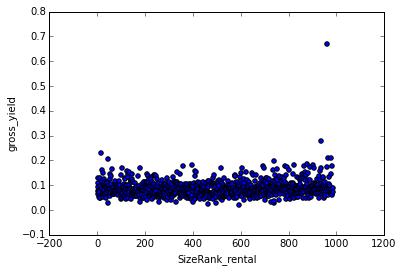

In [42]:
price_rental.plot(x='SizeRank_rental', y='gross_yield', kind='scatter')

The chart above suggest something quite interesting:
* There is one outlier
* There are cities across all sizes that outperform in terms of gross yield
* Most interesting is that it allows us to focus on the big cities that offer good yields

So let's dig in a bit further

### Outliers

In [43]:
price_rental.loc[price_rental.gross_yield > 0.5]

,RegionID,RegionName_price,State_price,Metro_price,CountyName_price,SizeRank_price,2015-10_price,location,RegionName_rental,State_rental,Metro_rental,CountyName_rental,SizeRank_rental,2015-10_rental,gross_yield
901,18451,Hampton Bays,NY,New York,Suffolk,4167,446800,Hampton Bays-NY,Hampton Bays,NY,New York,Suffolk,961,25000,0.671441


The most likely cause for this 70% gross yield is a data entry mistake - someone put in one extra zero. However, given the size of the city, not considering. 

### Focus on Top 50 Cities in SizeRank
We focus on the top 50 cities and order the new results by gross rental yield.

In [46]:
NUM_TOP_CITIES = 50
top_cities_sorted = price_rental.sort('SizeRank_price')[:NUM_TOP_CITIES].copy().sort('gross_yield', ascending=False)
top_cities_sorted[['RegionName_price', 
                   'State_price', 
                   'SizeRank_price', 
                   '2015-10_price', 
                   '2015-10_rental', 
                   'gross_yield']].head(20)

,RegionName_price,State_price,SizeRank_price,2015-10_price,2015-10_rental,gross_yield
12,Detroit,MI,13,39300,750,0.229008
37,Cleveland,OH,40,52000,900,0.207692
14,Memphis,TN,15,63500,850,0.160630
19,Baltimore,MD,20,105600,1300,0.147727
47,Corpus Christi,TX,51,128900,1550,0.144298
49,Pittsburgh,PA,53,102700,1185,0.138462
3,Houston,TX,4,147300,1600,0.130346
8,Dallas,TX,9,130200,1400,0.129032
23,Milwaukee,WI,24,94100,997,0.127141
46,Saint Louis,MO,50,92500,975,0.126486


Tentatively, a couple that looks quite interesting:
* Cleveland
* Memphis
* Baltimore
* Pittsburgh (too small?)
* Dallas
* Milwaukee